# Predicting patient readmission at hospitals

*Data Source* : Diabetes 130-US hospitals for years 1999-2008 Data Set ([link](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008#))

In [1]:
!pip install pandas numpy scipy statistics matplotlib sklearn IPython imblearn graphviz

In [2]:
import IPython
import pandas as pd
import numpy as np
from statistics import mode
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
df_ori = pd.read_csv("diabetic_data.csv")


### Features:
- age
- gender
- race
- diagnosis ( primary, secondary and other - ICD codes)
- Glucose serum , A1C test results
- medications used ( Ex : Insulin, Acetohexamide, Troglitazone, etc )
- ... and some more

### Data Pre-processing steps Overview
- Dropped unnecessary features and records
- Created new features (from existing features)
- Collapsed a few categorical variables into less number of categories
- Converted categorical variables into numerical
- Applied Log Transformation and Standardization to skewed features
- Removal of outliers
- Collapsed multiple encounters of a given patient
- Added interaction features identified from correlation matrix

In [4]:
#make a copy 
df = df_ori.copy(deep=True)


### Dropped Features

- _Weight_ is **missing** in over **98%** records. Owing to the poor interpretability of missing values and little predictive generalizability to other patients, we decided to drop it.
- **Nearly half** of the records are missing _Payer code_ and _Medical Specialty_ of treating physician, so we dropped these features too.

In [5]:
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)


### Dropped records

- Primary (diag_1), Secondary (diag_2) and Additional (diag_3) diagnoses were have very few missing values. Technically, if all three are missing, that’s bad data. So we only drop those records where all three diagnoses are missing.

- Gender has only 3 missing or invalid values so we decided to drop these records.

- Also, one more cleaning step that depends on understanding the data and some common sense: since we are trying to predict readmissions, those patients who died during this hospital admission, have zero probability of readmission. So we should remove those records (discharge_disposition = 11).

In [6]:
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

### Dropping insignificant fields

- We also noticed that for two variables (drugs named citoglipton and examide), all records have the same value. So essentially these cannot provide any interpretive or discriminatory information for predicting readmission, and we dropped these columns as well.

In [7]:
df = df.drop(['citoglipton', 'examide'], axis = 1)

## Creating new features

This is highly subjective, and partly depends on a knowledge of healthcare services, and making sense of the potential relationships between features. There are perhaps thousands of ways to try here. We tried some.


### Service Utilization :
The data contains variables for number of inpatient (admissions), emergency room visits and outpatient visits for a given patient in the previous one year. These are measures of how much hospital/clinic services a person has used in the past year. We added these three to create a new variable called service utilization.

In [8]:
df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

### No. of medications changed :
The dataset contains 23 features for 23 drugs which indicate for each of these, whether a change in that medication was made or not. We decided to count how many changes were made in total for each patient, and declared that a new feature. 

**Motivation** :
- Medication change for diabetics upon admission has been shown by previous research to be associated with lower readmission rates.
- Another reasoning here was to both simplify the model and possibly discover a relationship with number of changes regardless of which drug was changed.

In [9]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]

In [10]:
df['numchange'].value_counts()

0    72868
1    25832
2     1308
3      107
4        5
Name: numchange, dtype: int64

In [11]:
#change
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
#gender
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
#race
df['race'] = df['race'].replace('?', 'Other')
#df['race'] = df['race'].replace('Other', 0)
#df['race'] = df['race'].replace('AfricanAmerican', 1)
#df['race'] = df['race'].replace('Asian', 2)
#df['race'] = df['race'].replace('Caucasian', 3)
#df['race'] = df['race'].replace('Hispanic', 4)
#diabetesMed
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
# keys is the same as before
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)


### No. of medications used :
Since the no. of medications used may indicate severity of their condition and/or the intensity of care, we decided to create another feature.

In [12]:
df['nummed'] = 0
for col in keys:
    df['nummed'] = df['nummed'] + df[col]

### Categorization of diagnoses :
The dataset contained upto three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700–900 unique ICD codes and it is extremely difficult to include them in the model and interpret meaningfully. Therefore, we collapsed these diagnosis codes into 9 disease categories. These 9 categories include _Circulatory_, _Respiratory_, _Digestive_, _Diabetes_, _Injury_, etc.

In [13]:
# create a duplicate of the diagnosis column
df['level1_diag1'] = df['diag_1']
# disease codes starting with V or E are in “other” category; so recode them to 0
df.loc[df['diag_1'].str.contains('V'), ['level1_diag1']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag1']] = 0
# also replace the unknown values with -1
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
# iterate and recode disease codes between certain ranges to certain categories
df['level1_diag1'] = df['level1_diag1'].astype(float)
for index, row in df.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        df.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        df.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        df.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        df.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        df.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        df.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        df.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        df.loc[index, 'level1_diag1'] = 8
    else:
        df.loc[index, 'level1_diag1'] = 0


In [14]:
#change dtype of level1_diag1
df['level1_diag1'] = df['level1_diag1'].astype(float)

#drop diag_1, diag_2, diag_3
df = df.drop(['diag_1', 'diag_2', 'diag_3'], axis = 1)

In [15]:
df.to_csv('./diabetes_data_preprocessed.csv')

### Collapsing other variables :
Just like diagnoses, there were quite a few categories for admission source, admission type and discharge disposition. We collapsed these variables into fewer categories where it made sense.

In [16]:
df['admission_type_id'] = df['admission_type_id'].replace(2,1)
df['admission_type_id'] = df['admission_type_id'].replace(7,1)
df['admission_type_id'] = df['admission_type_id'].replace(6,5)
df['admission_type_id'] = df['admission_type_id'].replace(8,5)

In [17]:
#Discharge to specific type of hospital
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(2,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(3,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(29,2)

#Discharge to other hospital
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5,3)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(16,3)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(27,3)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(28,3)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(30,3)

#Discharge to same Hospital
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9,4)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15,4)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(17,4)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(12,4)

#Hospice
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,5)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(8,5)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(13,5)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(14,5)

#Expired
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(11,6)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(19,6)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(20,6)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(21,6)

#Others
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(7,7)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(18,7)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25,7)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(26,7)

#Neonatal
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(10,8)



In [18]:
#Referrals
df['admission_source_id'] = df['admission_source_id'].replace(1,1)
df['admission_source_id'] = df['admission_source_id'].replace(2,1)
df['admission_source_id'] = df['admission_source_id'].replace(3,1)

#Transfers
df['admission_source_id'] = df['admission_source_id'].replace(4,2)
df['admission_source_id'] = df['admission_source_id'].replace(5,2)
df['admission_source_id'] = df['admission_source_id'].replace(6,2)
df['admission_source_id'] = df['admission_source_id'].replace(7,2)
df['admission_source_id'] = df['admission_source_id'].replace(10,2)
df['admission_source_id'] = df['admission_source_id'].replace(18,2)
df['admission_source_id'] = df['admission_source_id'].replace(22,2)
df['admission_source_id'] = df['admission_source_id'].replace(25,2)
df['admission_source_id'] = df['admission_source_id'].replace(26,2)

#Birth place
df['admission_source_id'] = df['admission_source_id'].replace(23,3)
df['admission_source_id'] = df['admission_source_id'].replace(24,3)

#Birth Category
df['admission_source_id'] = df['admission_source_id'].replace(11,4)
df['admission_source_id'] = df['admission_source_id'].replace(12,4)
df['admission_source_id'] = df['admission_source_id'].replace(13,4)
df['admission_source_id'] = df['admission_source_id'].replace(14,4)

# Court/Law Enforcement
df['admission_source_id'] = df['admission_source_id'].replace(8,5)

#Readmission
df['admission_source_id'] = df['admission_source_id'].replace(19,6)

#Unknown
df['admission_source_id'] = df['admission_source_id'].replace(9,7)
df['admission_source_id'] = df['admission_source_id'].replace(15,7)
df['admission_source_id'] = df['admission_source_id'].replace(17,7)
df['admission_source_id'] = df['admission_source_id'].replace(20,7)
df['admission_source_id'] = df['admission_source_id'].replace(21,7)

### Recoding some variables :
The original dataset used string values for gender, race, medication change, and each of the 23 drugs used. To better fit those variables into our model, we interpret the variables to numeric binary variables to reflect their nature. For example, we encoded the “medication change” feature from “No” (no change) and “Ch” (changed) into 0 and 1.

In [19]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)
# keys is the same as before
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

In [20]:
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

In [21]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)



### Dealing with age :
The dataset only gives us age as 10 year categories, so we don’t know the exact age of each patient. We wanted to be able to see the effect of increasing age on readmission, even if in a crude way. To do that, we assume that age of the patient on average lies at the midpoint of the age category. For example, if the patient’s age category is 20–30 years, then we assume the age = 25 years.

In [22]:
age_dict = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}

In [23]:

df['age'] = df.age.map(age_dict)
df['age'] = df['age'].astype('int64')
              

### Log Transformation :
A preliminary analysis of our numerical features revealed that many of these were highly skewed which would impact standardization.
Features such as _No. of medications_, _No. of outpatient visits_ and _No. of emergency admissions_ has high skew.

In [24]:
import scipy as sp

df["num_medications" + "_log1p"] = np.log1p(df["num_medications"])
df["number_outpatient" + "_log1p"] = np.log1p(df["number_outpatient"])
df["number_inpatient" + "_log1p"] = np.log1p(df["number_inpatient"])
df["number_emergency" + "_log1p"] = np.log1p(df["number_emergency"])
df["service_utilization" + "_log1p"] = np.log1p(df["service_utilization"])
numerics = np.array(["num_medications_log1p", "number_outpatient_log1p","number_inpatient_log1p", "number_emergency_log1p", "service_utilization_log1p"])


### Standardization :
Since we had used log transformation to ensure that the numeric variables had a Gaussian-like or normal distribution, we decided to standardize our numerical features.

<img src="files/standard.png">

In [25]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))
# numerics is a list of all numeric features
df[numerics] = standardize(df[numerics])


### Removal of Outliers :
Anything within 3 SDs on either side of the mean would include 99.7% of our data and the remaining 0.3% we treated as outliers. Using this logic, we restricted our data to within 3 SDs on either side from the mean.

<img src="files/gausian.png">

In [26]:
df = df[(np.abs(sp.stats.zscore(df[numerics])) < 3).all(axis=1)]

### Collapsing of Multiple Encounters for same patient : 
We decided to use first encounters of patients with multiple encounters.

In [27]:
df = df.drop(['num_medications','number_outpatient','number_inpatient','number_emergency','service_utilization'],axis=1)
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2 = df2.drop(['patient_nbr','encounter_id'], axis=1)

### Interactions Terms : 
Variables can have interdependent effects on readmission. We can identify possible candidates for interaction terms by observing a correlation matrix of the predictor variables. 

In [28]:
interactionterms = [('num_medications_log1p','time_in_hospital'), ('num_medications_log1p','num_procedures'), ('time_in_hospital','num_lab_procedures'),
('num_medications_log1p','num_lab_procedures'), ('num_medications_log1p','number_diagnoses'),
('age','number_diagnoses'), ('change','num_medications_log1p'), ('number_diagnoses','time_in_hospital'), ('num_medications_log1p','numchange')]
 
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df2[name] = df2[inter[0]] * df2[inter[1]]

In [29]:
categorical_cols = [ 'level1_diag1', 'race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'max_glu_serum', 'A1Cresult' ]
df_catagorical = pd.concat([pd.get_dummies(df2[col], drop_first=True, prefix=col) for col in categorical_cols], axis=1)


In [30]:
df2 = df2.drop(categorical_cols, axis = 1)

In [31]:
df2.shape

(67685, 45)

In [32]:
df_catagorical.shape

(67685, 31)

In [33]:
df3=df2.join(df_catagorical)


In [34]:
df3.shape

(67685, 76)

In [35]:
df3.to_csv('./diabetes_data_final_features.csv')

In [36]:
input_array =list(df3.columns.values)
input_array.remove("readmitted")

In [37]:
train_input = df3[input_array]
train_output = df3["readmitted"]
train_input_no_int = train_input.drop(['num_medications_log1p|time_in_hospital', 'num_medications_log1p|num_procedures', 'time_in_hospital|num_lab_procedures', 'num_medications_log1p|num_lab_procedures', 'num_medications_log1p|number_diagnoses', 'age|number_diagnoses', 'change|num_medications_log1p', 'number_diagnoses|time_in_hospital', 'num_medications_log1p|numchange'], axis = 1)

## Model Training

### Data balancing :
Data was highly imbalanced with respect to readmissions (only 10% records for 30-day readmissions), leading to high accuracy. Moreover, the high accuracy could be attributed not to the generalizability of our model to diverse patient records but to the baseline accuracy of 90%: predicting that no patient would be readmitted.We used synthetic minority over-sampling technique (SMOTE) to oversample our underrepresented class of readmissions and obtain equal representation of our overrepresented and underrepresented classes.

In [39]:

from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_output)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(train_input, train_output)
#train_input_no_int = train_input_new.drop(['num_medications_log1p|time_in_hospital', 'num_medications_log1p|num_procedures', 'time_in_hospital|num_lab_procedures', 'num_medications_log1p|num_lab_procedures', 'num_medications_log1p|number_diagnoses', 'age|number_diagnoses', 'change|num_medications_log1p', 'number_diagnoses|time_in_hospital', 'num_medications_log1p|numchange'], axis = 1)
print('New dataset shape {}'.format(Counter(train_output_new)))

Original dataset shape Counter({0: 61701, 1: 5984})
New dataset shape Counter({0: 61701, 1: 61701})


In [40]:
train_input_small = train_input_new
train_output_small = train_output_new


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input_small, train_output_small, test_size=0.20, random_state=0)
logreg = LogisticRegression(fit_intercept=True, penalty='l1')
print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(logreg, X_train, Y_train, cv=10))))
logreg.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(logreg.score(X_dev, Y_dev)))

Cross Validation Score: 62.31%
Dev Set score: 61.93%


In [42]:
Y_dev_predict = logreg.predict(X_dev)
pd.crosstab(pd.Series(Y_dev, name = 'Actual'), pd.Series(Y_dev_predict, name = 'Predict'), margins = True)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_dev, Y_dev_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_dev, Y_dev_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_dev, Y_dev_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_dev, Y_dev_predict)))

Accuracy is 0.62
Precision is 0.63
Recall is 0.55
AUC is 0.62


In [43]:
######SMOTE for Decision Tree ########

In [44]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(train_output)))
smt = SMOTE(random_state=20)
train_input_no_int_new, train_output_new = smt.fit_sample(train_input_no_int, train_output)
print('New dataset shape {}'.format(Counter(train_output_new)))

Original dataset shape Counter({0: 61701, 1: 5984})
New dataset shape Counter({0: 61701, 1: 61701})


In [45]:
train_input_no_int_new= pd.DataFrame(train_input_no_int_new, columns = list(train_input_no_int.columns))
X_train, X_dev, Y_train, Y_dev = train_test_split(train_input_no_int_new, train_output_new, test_size=0.20, random_state=0)

In [46]:
from sklearn.tree import DecisionTreeClassifier
dte = DecisionTreeClassifier(max_depth=28, criterion = "gini", min_samples_split=10)
print("Cross Validation score: {:.2%}".format(np.mean(cross_val_score(dte, X_train, Y_train, cv=10))))
dte.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(dte.score(X_dev, Y_dev)))

Cross Validation score: 91.99%
Dev Set score: 92.18%


In [47]:
Y_dev_predict = dte.predict(X_dev)
pd.crosstab(pd.Series(Y_dev, name = 'Actual'), pd.Series(Y_dev_predict, name = 'Predict'), margins = True)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_dev, Y_dev_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_dev, Y_dev_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_dev, Y_dev_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_dev, Y_dev_predict)))

Accuracy is 0.92
Precision is 0.93
Recall is 0.91
AUC is 0.92


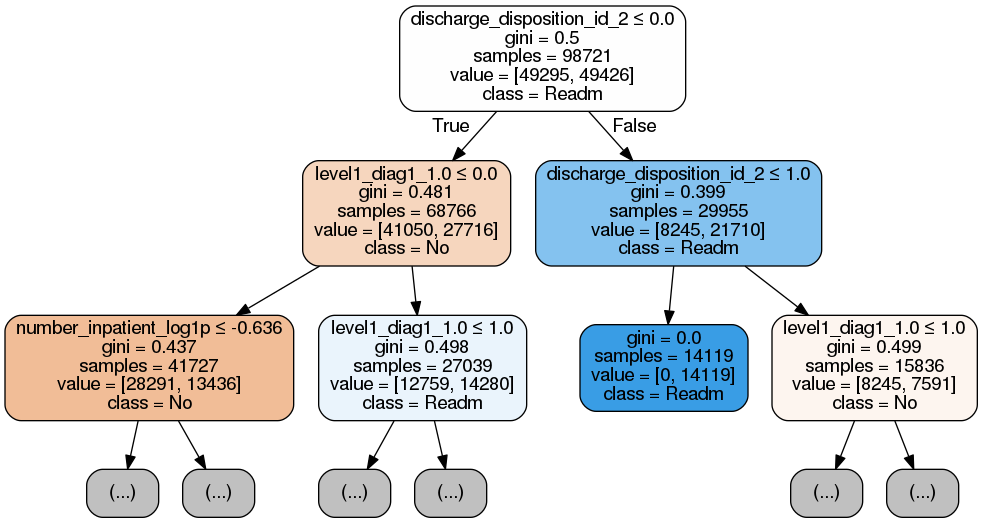

In [48]:
import graphviz
from IPython.display import Image
import pydotplus
from sklearn import tree
dot_dt_q2 = tree.export_graphviz(dte, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2, class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
Image(graph_dt_q2.create_png())

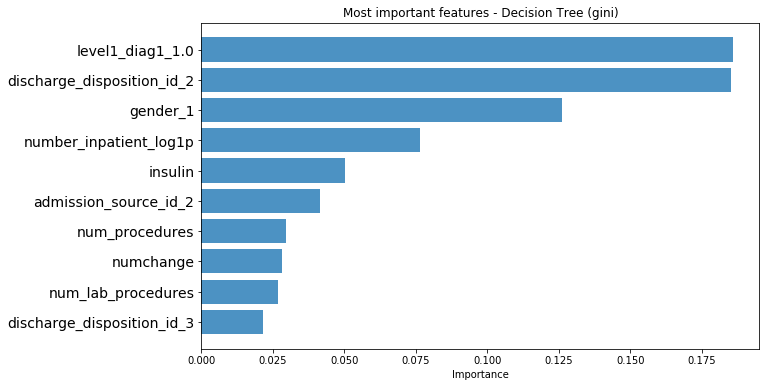

In [49]:
feature_names = X_train.columns
feature_imports = dte.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree (gini)')
plt.show()

In [50]:
##################Random Forest#####################

In [51]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=28, criterion = "gini", min_samples_split=10)
print("Cross Validation score: {:.2%}".format(np.mean(cross_val_score(rdf, X_train, Y_train, cv=10))))
rdf.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(rdf.score(X_dev, Y_dev)))

Cross Validation score: 94.89%
Dev Set score: 95.14%


In [52]:
Y_dev_predict = rdf.predict(X_dev)
pd.crosstab(pd.Series(Y_dev, name = 'Actual'), pd.Series(Y_dev_predict, name = 'Predict'), margins = True)
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_dev, Y_dev_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_dev, Y_dev_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_dev, Y_dev_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_dev, Y_dev_predict)))

Accuracy is 0.95
Precision is 1.00
Recall is 0.90
AUC is 0.95


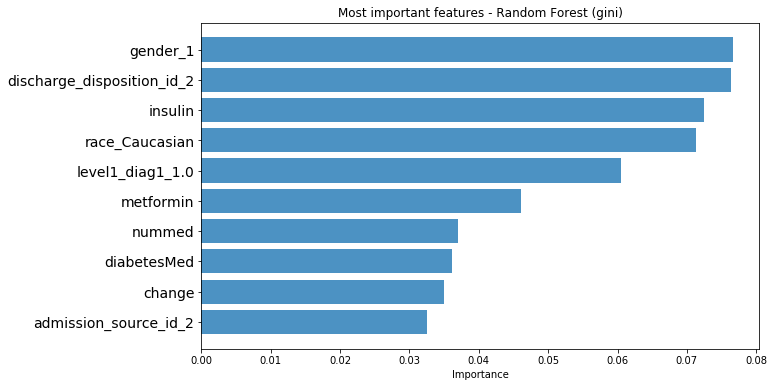

In [53]:
# Shot top most features based on importance
feature_names = X_train.columns
feature_imports = rdf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (gini)')
plt.show()